In [2]:
# ===================================================================
# 共通セットアップセル (ローカル / Colab 共通)
# ===================================================================
import sys
import os
from pathlib import Path

# --- 1. 環境判別 ---
IN_COLAB = False
try:
    # Colab環境でのみインポートが成功する
    from google.colab import drive
    IN_COLAB = True
except ImportError:
    pass # ローカル環境


if IN_COLAB:
    # ==================================
    # Colab 環境でのセットアップ
    # ==================================
    print("環境: Colab を検出。セットアップを開始します。")

    # 1. Google Driveのマウント
    drive.mount('/content/drive')

    # 2. GitHubリポジトリのクローンまたはプル
    repo_path = Path('/content/braidyn-bc')
    if repo_path.exists():
        print("リポジトリを pull します...")
        os.chdir(repo_path)
        !git pull
    else:
        print("リポジトリを clone します...")
        !git clone https://github.com/nyaamikeneko/braidyn-bc.git
        os.chdir(repo_path)

    # 3. 依存ライブラリのインストール
    print("依存ライブラリをインストールします...")
    !pip install -q pynwb git+https://github.com/BraiDyn-BC/bdbc-nwb-explorer.git

    # 4. sys.path の設定
    project_root = repo_path
    if str(project_root) not in sys.path:
        sys.path.append(str(project_root))

    print(f"セットアップ完了。プロジェクトルート: {project_root}")

else:
    # ==================================
    # ローカル (VSCode) 環境でのセットアップ
    # ==================================
    print("環境: ローカル (VSCode) を検出。")

    # 1. sys.path の設定
    current_dir = Path.cwd()
    if current_dir.name == 'notebooks':
        # ノートブックが notebooks/ から実行された場合
        project_root = current_dir.parent
    else:
        # プロジェクトルート (braidyn-bc/) から実行されたと仮定
        project_root = current_dir

    if str(project_root) not in sys.path:
        sys.path.append(str(project_root))

    print(f"プロジェクトルート: {project_root}")

# ===================================================================
# 共通インポート・処理
# (セットアップが完了したため、config.py や src/ が読み込める)
# ===================================================================
print("\n共通モジュールをインポートします...")

import bdbc_nwb_explorer as nwbx
import src.data_loader as dl
import config  # config.py もここで読み込める

print(f"データパス (DATA_NWB_ROOT): {config.DATA_NWB_ROOT}")

環境: Colab を検出。セットアップを開始します。
Mounted at /content/drive
リポジトリを clone します...
Cloning into 'braidyn-bc'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 125 (delta 49), reused 23 (delta 12), pack-reused 42 (from 1)
Receiving objects: 100% (125/125), 28.92 MiB | 25.48 MiB/s, done.
Resolving deltas: 100% (70/70), done.
依存ライブラリをインストールします...
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 339.5/339.5 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.2/788.2 kB 40.2 MB/s eta 0:00:00
セットアップ完了。プロジェクトルート: /content/braidyn-bc

共通モジュールをインポートします...
環境: Colab
データパス (DATA_NWB_ROOT): /content/driv

In [3]:
# --- 必要なデータを関数で読み出す ---
SESSION_ID = "VG1GC-66"
NWB_FILENAME = "VG1GC-66_2023-09-08_task-day15.nwb"
TASK_DAY_DIR = "task-day15"

# NWBデータの読み込み
# (dl は共通セルでインポート済み)
session = dl.load_nwb_session(SESSION_ID, NWB_FILENAME)

# CSVデータの読み込み
trials = dl.load_trials_csv(SESSION_ID, TASK_DAY_DIR)


NWB読み込み中: /content/drive/MyDrive/braidyn-bc/data/VG1GC-66/VG1GC-66_2023-09-08_task-day15.nwb
CSV読み込み中: /content/drive/MyDrive/hackathon_data/VG1GC-66/task-day15/trials_L1L2.csv
全試行数: 54000


CSV読み込み中: /content/drive/MyDrive/hackathon_data/VG1GC-66/task-day15/trials_L1L2.csv
全試行数: 54000


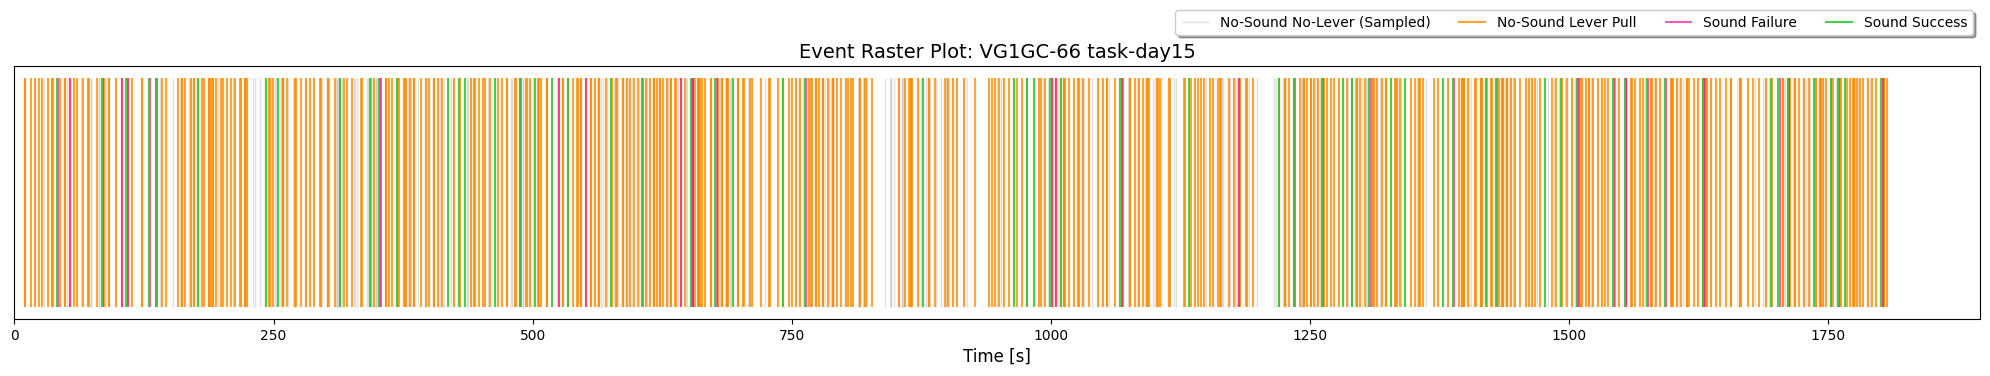

--- Event Counts for VG1GC-66 ---
Sound Success      : 63
Sound Failure      : 57
No-Sound Pull      : 455
No-Sound No-Pull   : 300 (Total: 40258)


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- 1. 定数・設定 ---
MOUSE_ID = "VG1GC-66"        # 解析対象のマウスID
TASK_DAY_DIR = "task-day15"  # 解析対象の日付ディレクトリ

# 閾値設定
THRESHOLD_UPPER = 3.0
THRESHOLD_DIFF = 0.04
SAMPLE_SIZE = 300            # 音なしレバー引きなしのサンプリング数

# 色設定
COLOR_SUCCESS = 'limegreen'
COLOR_FAILURE = 'deeppink'
COLOR_NS_PULL = 'darkorange'
COLOR_NS_NOPULL = 'silver'

# --- 2. データ読み込みと前処理 ---
# データの読み込み
df = dl.load_trials_csv(MOUSE_ID, TASK_DAY_DIR)
trials = df.copy()

# 数値型への変換とNaN処理（念のための正規化）
trials['diff_value'] = pd.to_numeric(trials['diff_value'], errors='coerce')
trials['pull_onset'] = pd.to_numeric(trials['pull_onset'], errors='coerce')
trials['t'] = pd.to_numeric(trials['t'], errors='coerce')

# --- 3. イベント分類ロジック ---

# (1) 音あり成功 (Sound Success)
# 条件: trial_outcomeがsuccess
success_trials = trials[trials['trial_outcome'] == 'success'].copy()
times_success = success_trials['pull_onset'].dropna()

# 重複排除用の時間セットを作成（小数点4桁で丸める）
success_times_set = set(times_success.round(4))

# (2) 音あり失敗 (Sound Failure)
# 条件: state_taskが1か2、かつ diff_value >= 0.04
cond_fail_task = trials['state_task'].isin([1, 2])
cond_fail_diff = trials['diff_value'] >= THRESHOLD_DIFF
candidates = trials[cond_fail_task & cond_fail_diff].copy()

# 時間算出: t - diff_value
candidates['calc_start_time'] = (candidates['t'] - candidates['diff_value'])

# 除外処理: 算出時間が「音あり成功」と一致するものを除外
# 比較のため丸め処理を適用して判定
is_overlap = candidates['calc_start_time'].round(4).isin(success_times_set)
failure_trials = candidates[~is_overlap]
times_failure = failure_trials['calc_start_time']

# (3) 音なしレバー引き (No-Sound Lever Pull)
# 条件: state_taskが0, state_leverが1, diff_value > 0.04
cond_ns_task = trials['state_task'] == 0
cond_ns_lever = trials['state_lever'] == 1
cond_ns_diff = trials['diff_value'] > THRESHOLD_DIFF

ns_pull_trials = trials[cond_ns_task & cond_ns_lever & cond_ns_diff].copy()
# 時間算出
times_ns_pull = ns_pull_trials['t'] - ns_pull_trials['diff_value']

# (4) 音なしレバー引きなし (No-Sound No-Lever)
# 条件: state_taskが0, state_leverが0
cond_ns_nl_task = trials['state_task'] == 0
cond_ns_nl_lever = trials['state_lever'] == 0

ns_nopull_trials = trials[cond_ns_nl_task & cond_ns_nl_lever].copy()
raw_times_nopull = ns_nopull_trials['t']

# サンプリング処理
if len(raw_times_nopull) > SAMPLE_SIZE:
    times_ns_nopull = raw_times_nopull.sample(n=SAMPLE_SIZE, random_state=42).sort_values()
else:
    times_ns_nopull = raw_times_nopull

# --- 4. 可視化 (ラスタープロット) ---
plt.figure(figsize=(20, 4))

# イベントごとのプロット (zIndexを考慮して描画順を調整)
# 1. 音なしレバー引きなし (背景・グレー)
plt.vlines(times_ns_nopull, ymin=0, ymax=1, color=COLOR_NS_NOPULL,
           alpha=0.5, linewidth=1.0, label='No-Sound No-Lever (Sampled)')

# 2. 音なしレバー引き (オレンジ)
plt.vlines(times_ns_pull, ymin=0, ymax=1, color=COLOR_NS_PULL,
           alpha=0.8, linewidth=1.5, label='No-Sound Lever Pull')

# 3. 音あり失敗 (マゼンタ)
plt.vlines(times_failure, ymin=0, ymax=1, color=COLOR_FAILURE,
           alpha=0.7, linewidth=1.5, label='Sound Failure')

# 4. 音あり成功 (緑・最前面)
plt.vlines(times_success, ymin=0, ymax=1, color=COLOR_SUCCESS,
           alpha=0.9, linewidth=1.5, label='Sound Success')

# スタイル調整
plt.xlabel('Time [s]', fontsize=12)
plt.yticks([]) # Y軸ラベルは不要なため削除
plt.title(f'Event Raster Plot: {MOUSE_ID} {TASK_DAY_DIR}', fontsize=14)
plt.legend(loc='upper right', framealpha=1.0, shadow=True,
           bbox_to_anchor=(1.0, 1.25), ncol=4)
plt.xlim(left=0) # 時間は0から開始
plt.tight_layout()

plt.show()

# --- 5. 集計結果の確認 ---
print(f"--- Event Counts for {MOUSE_ID} ---")
print(f"Sound Success      : {len(times_success)}")
print(f"Sound Failure      : {len(times_failure)}")
print(f"No-Sound Pull      : {len(times_ns_pull)}")
print(f"No-Sound No-Pull   : {len(times_ns_nopull)} (Total: {len(raw_times_nopull)})")

In [4]:
session.trials.data

,start_time,stop_time,pull_onset,reaction_time,pull_duration_for_success,trial_outcome
0,14.884000,15.917200,NaN,NaN,0.2,failure
1,32.250801,32.517399,32.450802,0.2206,0.2,miss
2,41.150799,43.617401,41.417400,0.2722,0.2,success
3,47.584202,48.584202,48.517601,0.9456,0.2,miss
4,53.584202,53.950802,53.850800,0.2870,0.2,miss
...,...,...,...,...,...,...
158,1752.362427,1754.862427,1752.662354,0.3160,0.2,success
159,1759.162354,1761.795776,1759.595825,0.4436,0.2,success
160,1765.929199,1768.395752,1766.195801,0.2744,0.2,success
161,1792.162598,1792.429443,1792.395996,0.2336,0.2,miss


In [5]:
import pandas as pd
import numpy as np

def process_glmhmm_data_refined(trials_df, session_nwb, gap_fill_limit=2, noise_remove_limit=2):
    """
    ユーザーの改善案に基づき、時系列データの整形を行ってからフラグを立てる関数。

    Process:
    1. Gap Filling: レバーを一瞬離した(0)と誤検知された短い区間を1で埋める。
    2. Noise Removal: 一瞬だけ引いた(1)短いノイズ区間を0で消す。
    3. Flag Creation: 整形された時系列に基づいてAction(Onset)等を定義する。

    Args:
        trials_df (pd.DataFrame): 生のCSVデータ
        session_nwb (object): NWBセッションデータ
        gap_fill_limit (int): このフレーム数以下の「0」の連続はセンサーエラーとみなし「1」で埋める (Default: 2)
        noise_remove_limit (int): このフレーム数以下の「1」の連続はノイズとみなし「0」にする (Default: 2)
            ※注意: 30Hzの場合、Limit=2だと0.066s以下の引きが消えるため、
              Strictに>0.04sを守るならLimit=1推奨。

    Returns:
        pd.DataFrame: 処理済みDataFrame
    """
    df = trials_df.copy()

    # NWBデータ処理用（事前準備）
    try:
        if hasattr(session_nwb, 'trials') and hasattr(session_nwb.trials, 'to_dataframe'):
            nwb_trials_df = session_nwb.trials.to_dataframe()
        else:
            nwb_trials_df = pd.DataFrame(session_nwb.trials.data)
    except Exception as e:
        print(f"NWB Read Error: {e}")
        nwb_trials_df = pd.DataFrame()

    # --- Phase 1: Lever State Cleaning (時系列整形) ---
    # 作業用の一時カラムを作成
    df['cleaned_lever'] = df['state_lever'].fillna(0).astype(int)

    def filter_consecutive_runs(series, target_val, max_len, fill_val):
        """
        seriesの中で target_val が max_len 以下しか続かない箇所を fill_val に書き換える
        """
        # ランレングス圧縮のようなロジックで連続区間を識別
        # 1. 値が変化した場所を特定し、グループIDを振る
        groups = (series != series.shift()).cumsum()
        # 2. 各グループの長さを計算
        counts = series.groupby(groups).transform('count')
        # 3. 条件に合致するマスクを作成 (値がtargetで、かつ長さがlimit以下)
        mask = (series == target_val) & (counts <= max_len)
        # 4. 書き換え
        series[mask] = fill_val
        return series

    # 1-1. マイクロギャップの埋め合わせ (0 -> 1)
    # ずっと引いているのに一瞬(2行以下)だけ0になっている箇所を1にする
    df['cleaned_lever'] = filter_consecutive_runs(
        df['cleaned_lever'], target_val=0, max_len=gap_fill_limit, fill_val=1
    )

    # 1-2. ショートプル(ノイズ)の除去 (1 -> 0)
    # diff_valueを使わず、整形後の時系列で短い(2行以下)1の連続を0にする
    df['cleaned_lever'] = filter_consecutive_runs(
        df['cleaned_lever'], target_val=1, max_len=noise_remove_limit, fill_val=0
    )

    # --- Phase 2: Create Input Flags ---

    df['stimulus'] = 0
    df['action'] = 0
    df['reward'] = 0

    # 2-1. Stimulus
    # state_task=1 (Sound) のみを Stimulus=1 とする（Reward Phaseのstate_task=2は除外）
    if 'state_task' in df.columns:
        df.loc[df['state_task'] == 1, 'stimulus'] = 1

    # 2-2. Action (Onset)
    # 整形後の cleaned_lever が 0 -> 1 に変化したタイミングを取得
    # diff() = 1 となる行が onset
    lever_diff = df['cleaned_lever'].diff()
    df.loc[lever_diff == 1, 'action'] = 1

    # 2-3. Reward
    # NWBのsuccess試行 onset 時間と照合 (Nearest Neighbor)
    if not nwb_trials_df.empty:
        success_trials = nwb_trials_df[nwb_trials_df['trial_outcome'] == 'success'].copy()
        if not success_trials.empty:
            # NWB側のOnset時刻
            reward_targets = pd.DataFrame({
                'reward_t': success_trials['pull_onset'],
                'flag': 1
            }).sort_values('reward_t')

            # DF側もソート
            df = df.sort_values('t')

            # merge_asof で時刻合わせ
            merged = pd.merge_asof(
                df,
                reward_targets,
                left_on='t',
                right_on='reward_t',
                direction='nearest',
                tolerance=0.034 # 1フレーム分程度の許容
            )
            df['reward'] = merged['flag'].fillna(0).astype(int)

    # --- Phase 3: Comparison (Validation用) ---
    # 確認用に元のdiff_value由来の判定と比較したい場合のためにカラムを残すか、
    # ユーザー確認用にプリント出力する

    # print(f"Original 1s count: {df['state_lever'].sum()}")
    # print(f"Cleaned  1s count: {df['cleaned_lever'].sum()}")

    return df

# --- 実行例 ---
processed_trials = process_glmhmm_data_refined(trials, session)


/tmp/ipython-input-41556580.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series[mask] = fill_val
/tmp/ipython-input-41556580.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series[mask] = fill_val


Plotting validation for time range: 100s - 130s


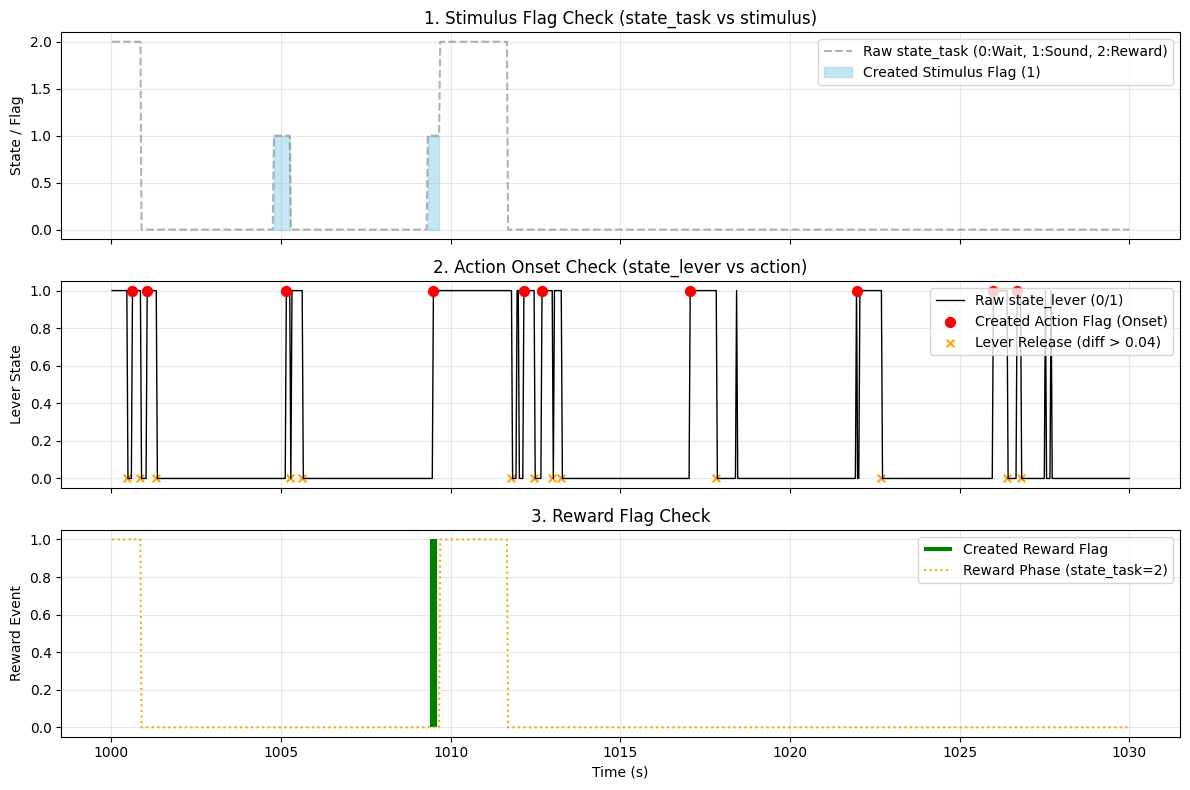

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_validation(df, start_time=0, duration=30):
    """
    処理済みデータの妥当性を確認するための可視化関数。
    指定した時間枠(duration)でズームインして表示します。

    Args:
        df (pd.DataFrame): create_glmhmm_inputsで処理済みのDataFrame
        start_time (float): 表示開始時間 (秒)
        duration (float): 表示する期間 (秒)
    """
    # 表示範囲のデータを抽出
    end_time = start_time + duration
    subset = df[(df['t'] >= start_time) & (df['t'] <= end_time)].copy()

    if subset.empty:
        print(f"No data found between {start_time}s and {end_time}s")
        return

    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

    # --- Plot 1: Stimulus Validation ---
    # 元のタスク状態(state_task)と、作成したstimulusフラグの比較
    ax0 = axes[0]
    ax0.set_title('1. Stimulus Flag Check (state_task vs stimulus)')
    ax0.plot(subset['t'], subset['state_task'], label='Raw state_task (0:Wait, 1:Sound, 2:Reward)', color='gray', linestyle='--', alpha=0.6)
    # stimulus=1の箇所を塗りつぶし
    ax0.fill_between(subset['t'], 0, 1, where=(subset['stimulus']==1), color='skyblue', alpha=0.5, label='Created Stimulus Flag (1)')
    ax0.set_ylabel('State / Flag')
    ax0.legend(loc='upper right')
    ax0.grid(True, alpha=0.3)

    # --- Plot 2: Action (Onset) Validation ---
    # 元のレバー状態(state_lever)と、計算されたactionタイミングの比較
    ax1 = axes[1]
    ax1.set_title('2. Action Onset Check (state_lever vs action)')
    ax1.plot(subset['t'], subset['state_lever'], label='Raw state_lever (0/1)', color='black', linewidth=1)

    # Actionフラグが立った場所を赤い点でプロット
    actions = subset[subset['action'] == 1]
    ax1.scatter(actions['t'], [1]*len(actions), color='red', s=50, zorder=5, label='Created Action Flag (Onset)')

    # 参考: diff_value（レバー持続時間）がある場所を表示（リリース時点）
    releases = subset[subset['diff_value'] > 0.04]
    if not releases.empty:
        ax1.scatter(releases['t'], [0]*len(releases), color='orange', marker='x', s=30, label='Lever Release (diff > 0.04)')

    ax1.set_ylabel('Lever State')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)

    # --- Plot 3: Reward Validation ---
    # 作成されたRewardフラグの確認
    ax2 = axes[2]
    ax2.set_title('3. Reward Flag Check')

    # Rewardフラグを緑のバーで表示
    rewards = subset[subset['reward'] == 1]
    if not rewards.empty:
        ax2.vlines(rewards['t'], 0, 1, color='green', linewidth=3, label='Created Reward Flag')

    # 参考としてstate_task=2（報酬フェーズ）も表示
    ax2.plot(subset['t'], (subset['state_task']==2).astype(int), color='orange', linestyle=':', label='Reward Phase (state_task=2)')

    ax2.set_ylabel('Reward Event')
    ax2.set_xlabel('Time (s)')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# --- 実行例 ---
# データフレーム全体を表示すると30Hzのイベントが見えないため、
# 任意の30秒間（例: 100秒〜130秒）を切り出して確認します。
# processed_trials は前段の関数で生成されたものを使用してください。

print("Plotting validation for time range: 100s - 130s")
plot_validation(processed_trials, start_time=1000, duration=30)


In [7]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_glmhmm_design_matrix(df, start_time=0, duration=20):
    """
    GLM-HMMの入力変数（Design Matrix）を可視化し、
    ラグ処理と減衰（Decay）が正しく行われているか確認する。

    Args:
        df (pd.DataFrame): create_design_matrixで作成されたデータフレーム
        start_time (float): 表示開始時間 (秒)
        duration (float): 表示期間 (秒)
    """
    # 指定範囲の切り出し
    end_time = start_time + duration
    subset = df[(df['t'] >= start_time) & (df['t'] <= end_time)].copy()

    if subset.empty:
        print(f"No data found between {start_time}s and {end_time}s")
        return

    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

    # 共通のX軸 (時間)
    times = subset['t']

    # --- 1. Stimulus & Action ($y_t$) ---
    ax0 = axes[0]
    ax0.set_title('1. Stimulus & Output ($y_t$)')

    # 音刺激 (x_stim) を背景として表示
    ax0.fill_between(times, 0, 1, where=(subset['x_stim']==1),
                     color='skyblue', alpha=0.4, label='Stimulus ($x_{stim}$)')

    # レバー引き ($y$) をスパイクとして表示
    # y=1 の点だけをプロット
    actions = subset[subset['y'] == 1]
    ax0.stem(actions['t'], [1]*len(actions), linefmt='k-', markerfmt='ko', basefmt=' ', label='Action ($y_t$)')

    ax0.set_ylabel('Binary State')
    ax0.legend(loc='upper right')
    ax0.grid(True, alpha=0.3)

    # --- 2. Action History ($x_{hist}$) ---
    ax1 = axes[1]
    ax1.set_title('2. Action History ($x_{hist}$) - Check 1-bin lag')

    # 履歴項 (連続値)
    ax1.plot(times, subset['x_hist'], color='purple', linewidth=2, label='Action History')

    # 比較用にAction発生点を薄く表示
    ax1.scatter(actions['t'], [0]*len(actions), color='black', marker='^', s=50, alpha=0.5, label='Action Event')

    ax1.set_ylabel('History Value')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)

    # --- 3. Reward History ($x_{rew}$) ---
    ax2 = axes[2]
    ax2.set_title('3. Reward History ($x_{rew}$) - Slow Decay')

    # 報酬履歴 (連続値)
    ax2.plot(times, subset['x_rew'], color='green', linewidth=2, label='Reward History')

    # 参考: 報酬履歴が立ち上がっている始点を探す
    # x_rewが増加したポイント = 報酬発生の次のビン
    rew_increases = subset[subset['x_rew'].diff() > 0]
    if not rew_increases.empty:
        ax2.scatter(rew_increases['t'], rew_increases['x_rew'], color='green', marker='o', s=50, label='History Jump')

    ax2.set_ylabel('History Value')
    ax2.set_xlabel('Time (s)')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


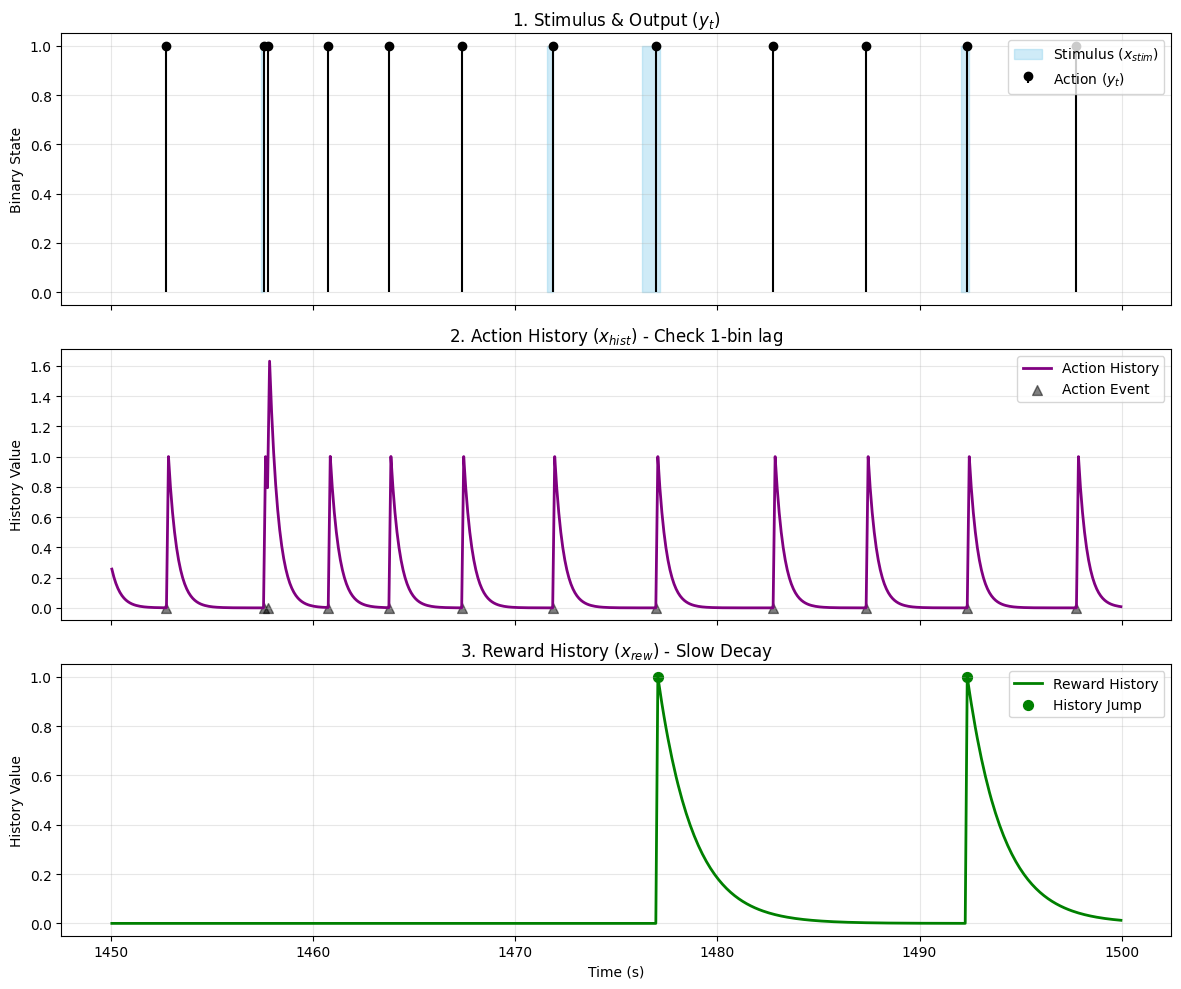

In [8]:
import pandas as pd
import numpy as np

def create_design_matrix_v2(cleaned_df, bin_width=3):
    """
    30Hz -> 10Hz変換と共変量作成。
    【修正点】Rewardの連続発生を防ぎ、履歴が2.0に跳ねるのを防止。
    """
    # ---------------------------------------------------------
    # 1. Downsampling (Binning)
    # ---------------------------------------------------------
    n_rows = len(cleaned_df)
    bin_ids = np.arange(n_rows) // bin_width

    binned_df = cleaned_df.groupby(bin_ids).agg({
        't': 'min',
        'stimulus': 'max',
        'action': 'max', # Onset (0->1)
        'reward': 'max', # Event
    }).reset_index(drop=True)

    # ---------------------------------------------------------
    # 【追加処理】Reward Debouncing (連続した1を排除)
    # ---------------------------------------------------------
    # Rewardが[0, 1, 1, 0]となっている場合、[0, 1, 0, 0]にする
    # diffをとって、1(立ち上がり)の箇所だけを残すのと同義（ただし最初の行の考慮が必要）

    # ロジック: 現在が1でも、直前が1なら0にする
    rew_vals = binned_df['reward'].values
    # 先頭以外の連続している1を0にするマスク
    mask = (rew_vals[1:] == 1) & (rew_vals[:-1] == 1)
    # マスク箇所（インデックスは+1ずれる）を0に書き換え
    rew_vals[1:][mask] = 0
    binned_df['reward'] = rew_vals

    # ---------------------------------------------------------
    # 2. Define Parameters & Create Covariates
    # ---------------------------------------------------------
    alpha_act = np.exp(np.log(0.1) / 10) # ~0.80
    alpha_rew = np.exp(np.log(0.1) / 40) # ~0.94

    y = binned_df['action'].values
    r = binned_df['reward'].values
    T = len(y)

    hist_act = np.zeros(T)
    hist_rew = np.zeros(T)

    prev_h_act = 0.0
    prev_h_rew = 0.0

    for t in range(1, T):
        # Action History
        hist_act[t] = y[t-1] + alpha_act * prev_h_act
        prev_h_act = hist_act[t]

        # Reward History
        # Rewardが連続しなくなったため、r[t-1]は単発の1となり、
        # prev_h_rewに残存があっても 1 + (decayed value) < 2.0 に収まるはずですが、
        # 論理的には 1 + 0.94 = 1.94 になる可能性はまだあります(直前の履歴が消えきっていない場合)。
        # ただし「連続したReward」によるブーストは防げます。
        hist_rew[t] = r[t-1] + alpha_rew * prev_h_rew
        prev_h_rew = hist_rew[t]

    binned_df['y'] = y
    binned_df['x_bias'] = 1
    binned_df['x_stim'] = binned_df['stimulus']
    binned_df['x_hist'] = hist_act
    binned_df['x_rew']  = hist_rew

    # ---------------------------------------------------------
    # Output Cleaning
    # ---------------------------------------------------------
    output_cols = ['t', 'y', 'x_bias', 'x_stim', 'x_hist', 'x_rew', 'session_id']
    final_cols = [c for c in output_cols if c in binned_df.columns]

    return binned_df[final_cols]

# --- 実行例 ---
glmhmm_input = create_design_matrix_v2(processed_trials)
plot_glmhmm_design_matrix(glmhmm_input, start_time=1450, duration=50)

In [9]:
import pandas as pd
import numpy as np

def split_data_by_iti(df, gap_threshold_sec=10.0, bin_width_sec=0.1):
    """
    長いITI（音も行動もない区間）を検出し、データをそこで分割してリスト化する。
    GLM-HMM (ssmライブラリ) の入力形式である [Array(T1, D), Array(T2, D)...] を作成する。

    Args:
        df (pd.DataFrame): create_design_matrix_v2 で作成されたデータフレーム
        gap_threshold_sec (float): この秒数以上の空白があればデータを切断する
        bin_width_sec (float): 1ビンの秒数 (通常0.1s)

    Returns:
        list of pd.DataFrame: 分割されたデータフレームのリスト
        list of np.ndarray: モデル入力用の 'y' (actions) リスト
        list of np.ndarray: モデル入力用の 'x' (covariates) リスト
    """
    # 閾値をビン数に換算
    gap_bins = int(gap_threshold_sec / bin_width_sec)

    # 1. 「データが存在すべき有効なビン」のマスクを作成
    # 保持条件: Stimulusがある OR Actionがある OR Historyが残っている
    # ※要件定義では「Silence & No Action」をカットとあるため、Stimulus=0 かつ y=0 を対象とします。
    # Historyの残存期間も考慮すべきですが、単純なITIカットとしては「刺激も行動もない」で判定するのが一般的です。

    is_active = (df['x_stim'] == 1) | (df['y'] == 1)

    # 2. 連続する「非アクティブ(0)」区間の長さを計算する
    # Run-Length Encodingのようなロジック

    # False(0)の連続をカウントするために、値を反転させてグループ化
    # active=True(1), inactive=False(0)

    # 状態が変化したタイミングでグループIDを変える
    condition = is_active.astype(int)
    groups = (condition != condition.shift()).cumsum()

    # 各グループのサイズを計算
    group_sizes = condition.groupby(groups).transform('size')

    # 3. 「非アクティブ かつ 長さが閾値以上」の行を特定
    # is_activeがFalse(0) かつ サイズ >= gap_bins の場所が「削除対象(drop)」
    to_drop = (~is_active) & (group_sizes >= gap_bins)

    # 4. データを分割
    # to_dropが True の場所は捨て、False の場所を残すが、
    # 連続性が途切れた場所でリストを分割する必要がある。

    # 残す行だけのDFを作成
    valid_df = df[~to_drop].copy()

    # 元のインデックスを使って、連続していない箇所（ジャンプした箇所）を検出
    # indexの差分が1より大きい場所が切れ目
    diffs = valid_df.index.to_series().diff()
    split_points = diffs[diffs > 1].index

    # セッションIDが変わる場所も本来は分割点だが、ここでは単一セッションまたはindexジャンプで対応可能
    # データフレームを切れ目で分割してリストに格納

    split_dfs = []

    # インデックスの位置を取得
    # searchsorted等も使えるが、単純にループで処理（可読性重視）
    last_idx = 0
    # split_pointsは元のDataFrameのindexを持っているので、valid_df内での位置(iloc)に変換が必要
    # reset_indexして新しい連番を作る方が安全

    valid_df_reset = valid_df.reset_index(drop=True)

    # 元のインデックスの差分を見て、新しいDF上での切れ目を探す
    # 元indexのdiff > 1 の場所を探す
    original_indices = valid_df.index.values
    if len(original_indices) == 0:
        return [], [], []

    # 切れ目の配列インデックスを見つける
    break_indices = np.where(np.diff(original_indices) > 1)[0] + 1

    # numpy.splitで一括分割
    df_splits = np.split(valid_df_reset, break_indices)

    # 出力用リストの作成
    final_dfs = []
    ys = [] # List of (T, 1) or (T,)
    xs = [] # List of (T, D)

    input_cols = ['x_bias', 'x_stim', 'x_hist', 'x_rew']

    for sub_df in df_splits:
        if len(sub_df) == 0:
            continue

        final_dfs.append(sub_df)

        # ssmライブラリ用: yは (T, 1) または (T, C) のint型
        # Bernoulliの場合は (T, 1)
        y_arr = sub_df[['y']].values.astype(int)
        ys.append(y_arr)

        # xは (T, D) のfloat型
        x_arr = sub_df[input_cols].values.astype(float)
        xs.append(x_arr)

    return final_dfs, ys, xs

# --- 実行例 ---
glmhmm_input = create_design_matrix_v2(processed_trials)

# ITIカット実行 (10秒以上の空白で分割)
train_dfs, train_ys, train_xs = split_data_by_iti(glmhmm_input, gap_threshold_sec=10.0)

# 確認
print(f"Original length: {len(glmhmm_input)}")
print(f"Number of segments: {len(train_ys)}")
for i, chunk in enumerate(train_dfs):
    print(f"Segment {i}: Length {len(chunk)} bins ({len(chunk)*0.1:.1f} sec)")
#     # 中身の確認
    print(chunk.head())

Original length: 18000
Number of segments: 1
Segment 0: Length 18000 bins (1800.0 sec)
        t  y  x_bias  x_stim  x_hist  x_rew
0  8.7506  0       1       0     0.0    0.0
1  8.8506  0       1       0     0.0    0.0
2  8.9506  0       1       0     0.0    0.0
3  9.0506  0       1       0     0.0    0.0
4  9.1506  0       1       0     0.0    0.0


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


### `train_ys` のデータ構造

`train_ys` は、GLM-HMMモデルの**観測データ**（Output）として使われる、NumPyアレイのリストです。

- **形式**: `list` of `numpy.ndarray`
- **各要素の形状**: `(T_segment, 1)`
  - `T_segment`: そのセグメント（時系列の断片）の総時間ビン数（1ビン = 0.1秒）
  - `1`: 観測次元。この場合、各時間ビンにおける「レバー引きの有無」（`action` フラグ、0または1）を表します。

つまり、`train_ys` の各要素は、ある連続した時間区間におけるレバー引きの時系列データを含んでいます。

### `train_xs` のデータ構造

`train_xs` は、GLM-HMMモデルの**入力共変量**（Input）として使われる、NumPyアレイのリストです。

- **形式**: `list` of `numpy.ndarray`
- **各要素の形状**: `(T_segment, M)`
  - `T_segment`: そのセグメントの総時間ビン数（`train_ys` の対応する要素と同じ）
  - `M`: 入力共変量の数。ここでは `4` つの共変量（Bias, Stimulus, Action History, Reward History）が含まれています。

具体的には、`train_xs` の各要素は、対応する時間区間における以下の4つの共変量の時系列データを含んでいます。

1.  **`x_bias`**: 定数項 (常に1)
2.  **`x_stim`**: 刺激の有無 (0または1)
3.  **`x_hist`**: 過去の行動履歴（減衰する連続値）
4.  **`x_rew`**: 過去の報酬履歴（減衰する連続値）

これらのリストは、`split_data_by_iti` 関数によって、長い休憩時間（ITI）で分割されたデータセグメントごとに作成されています。

In [11]:
!git clone https://github.com/lindermanlab/ssm
!pip install numpy cython
%cd ssm
!pip install -e .
%cd ..

Cloning into 'ssm'...
remote: Enumerating objects: 3347, done.
remote: Counting objects: 100% (1296/1296), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 3347 (delta 1252), reused 1220 (delta 1220), pack-reused 2051 (from 2)
Receiving objects: 100% (3347/3347), 53.78 MiB | 26.22 MiB/s, done.
Resolving deltas: 100% (2362/2362), done.
Obtaining file:///content/braidyn-bc
ERROR: file:///content/braidyn-bc does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


Start training GLM-HMM with 3 states...
Input dims: 4, Obs dims: 1, Categories: 2


  0%|          | 0/200 [00:00<?, ?it/s]

Seed 0: Final Log Likelihood = -2044.57


  0%|          | 0/200 [00:00<?, ?it/s]

Seed 1: Final Log Likelihood = -2036.25


  0%|          | 0/200 [00:00<?, ?it/s]

Seed 2: Final Log Likelihood = -2039.95


  0%|          | 0/200 [00:00<?, ?it/s]

Seed 3: Final Log Likelihood = -2036.34


  0%|          | 0/200 [00:00<?, ?it/s]

Seed 4: Final Log Likelihood = -2044.31

Best Log Likelihood: -2036.25


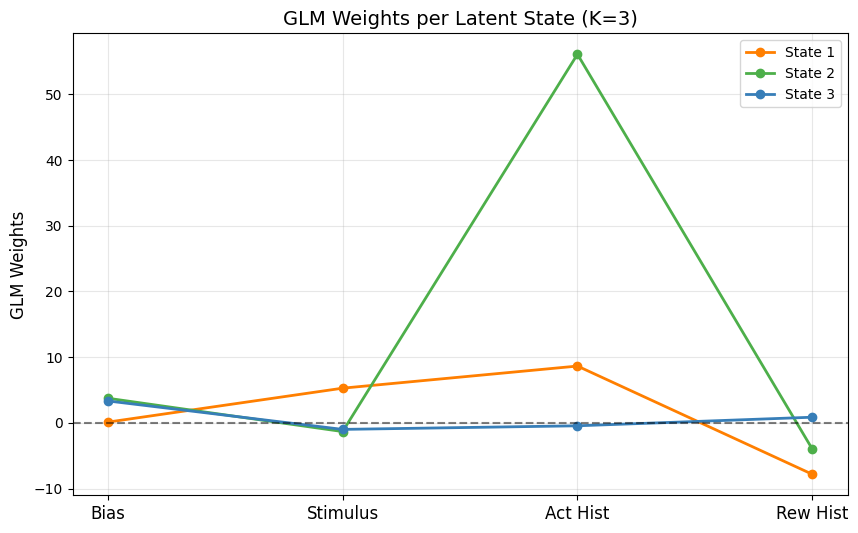


Transition Matrix (State t -> State t+1):
[[0.863 0.137 0.   ]
 [0.006 0.989 0.005]
 [0.001 0.076 0.924]]


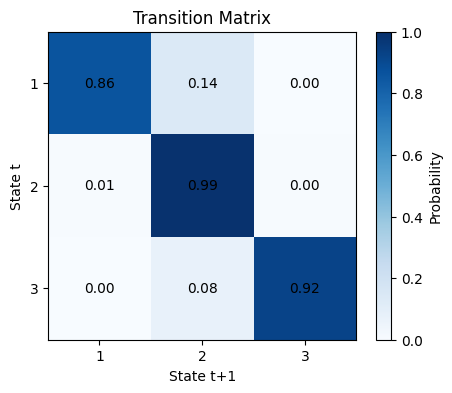

In [24]:
import numpy as np
import ssm
import matplotlib.pyplot as plt

def train_glmhmm(train_ys, train_xs, num_states=3, num_iters=200, seeds=[0, 1, 2, 3, 4]):
    """
    要件定義に基づきBernoulli GLM-HMMを作成・学習する関数。
    初期値依存を避けるため、複数のシードで学習を行い、尤度が最も高いモデルを採用します。

    Parameters
    ----------
    train_ys : list of np.ndarray
        Action flag list. 各要素は (T_segment, 1)
    train_xs : list of np.ndarray
        Input regressors list. 各要素は (T_segment, 4)
        [Bias, Stimulus, Action History, Reward History]
    num_states : int
        潜在状態数 (要件では2~3を想定)
    num_iters : int
        EMアルゴリズムの最大イテレーション数
    seeds : list of int
        初期化に使用するランダムシードのリスト

    Returns
    -------
    best_model : ssm.HMM
        学習済みモデル（最良尤度）
    best_ll : float
        最良モデルの対数尤度
    """

    # --- 1. パラメータ設定 (Hyperparameters) ---
    # Observation Model: Bernoulli (C=2 categories: 0 or 1)
    # Input Dimensions: 4 (Bias, Stimulus, ActHist, RewHist)
    # Output Dimensions: 1 (Action)

    obs_dim = 1           # 観測次元 (Action有無)
    input_dim = 4         # 入力次元 (Bias, Stimulus, ActHist, RewHist)
    num_categories = 2    # ベルヌーイ分布 (Binary)

    # --- 2. モデル学習 (Training Loop) ---
    best_model = None
    best_ll = -np.inf

    print(f"Start training GLM-HMM with {num_states} states...")
    print(f"Input dims: {input_dim}, Obs dims: {obs_dim}, Categories: {num_categories}")

    for seed in seeds:
        np.random.seed(seed)

        # GLM-HMMの初期化
        # 修正点: observations="input_driven_obs" を使用 (以前のエラー回避)
        glmhmm = ssm.HMM(
            K=num_states,
            D=obs_dim,
            M=input_dim,
            observations="input_driven_obs",
            observation_kwargs=dict(C=num_categories),
            transitions="standard"
        )

        # モデルのフィッティング (EMアルゴリズム)
        try:
            lls = glmhmm.fit(
                train_ys,
                inputs=train_xs,
                method="em",
                num_iters=num_iters,
                tolerance=10**-4
            )

            final_ll = lls[-1]
            print(f"Seed {seed}: Final Log Likelihood = {final_ll:.2f}")

            # 最良モデルの更新
            if final_ll > best_ll:
                best_ll = final_ll
                best_model = glmhmm

        except Exception as e:
            print(f"Seed {seed} failed with error: {e}")
            continue

    if best_model is None:
        raise RuntimeError("All training attempts failed.")

    print(f"\nBest Log Likelihood: {best_ll:.2f}")
    return best_model, best_ll

# --- 3. 実行と重みの可視化 (Execution & Visualization) ---

# 実際のデータがある前提での実行例
# train_ys, train_xs は別途生成済みとする
try:
    # 状態数3で学習 (要件: 2~3状態)
    K = 3
    model, ll = train_glmhmm(train_ys, train_xs, num_states=K)

    # --- 4. 結果の解釈 (Weights Analysis) ---
    # GLMの重み (Weights) を取得: shape (K, 1, M) -> (K, M) for visualization
    # Wk shape in ssm: (K, C-1, M) where C=2. So we want model.observations.params

    glm_weights = model.observations.params
    # shape is (K, C-1, M) -> (K, 1, 4) for binary

    feature_names = ['Bias', 'Stimulus', 'Act Hist', 'Rew Hist']

    # 重みのプロット
    plt.figure(figsize=(10, 6))
    colors = ['#ff7f00', '#4daf4a', '#377eb8'] # カラーパレット

    for k in range(K):
        # 状態kの重みベクトル (State k, Class 1 probability weights)
        w_k = glm_weights[k][0]

        plt.plot(range(len(feature_names)), w_k, marker='o',
                 label=f'State {k+1}', color=colors[k%len(colors)], linewidth=2)

    plt.axhline(0, color='black', linestyle='--', alpha=0.5)
    plt.xticks(range(len(feature_names)), feature_names, fontsize=12)
    plt.ylabel("GLM Weights", fontsize=12)
    plt.title(f"GLM Weights per Latent State (K={K})", fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # --- 5. 遷移確率行列 (Transition Matrix) ---
    transition_matrix = np.exp(model.transitions.params)[0] # stationary transition

    print("\nTransition Matrix (State t -> State t+1):")
    print(np.round(transition_matrix, 3))

    plt.figure(figsize=(5, 4))
    plt.imshow(transition_matrix, vmin=0, vmax=1, cmap='Blues')
    plt.colorbar(label="Probability")
    plt.title("Transition Matrix")
    plt.xlabel("State t+1")
    plt.ylabel("State t")
    plt.xticks(range(K), range(1, K+1))
    plt.yticks(range(K), range(1, K+1))
    for i in range(K):
        for j in range(K):
            plt.text(j, i, f"{transition_matrix[i, j]:.2f}",
                     ha='center', va='center', color='black')
    plt.show()

except NameError:
    print("Error: 'train_ys' and 'train_xs' are not defined. Please prepare the input data first.")

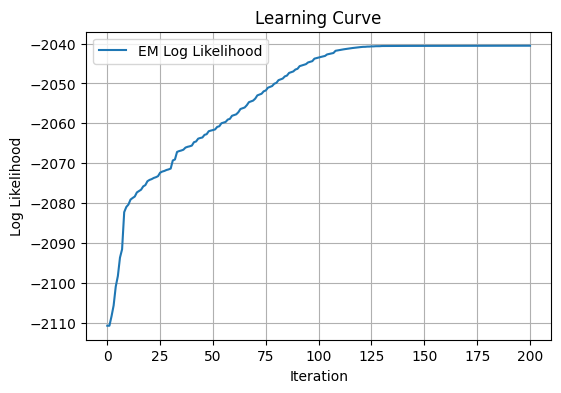

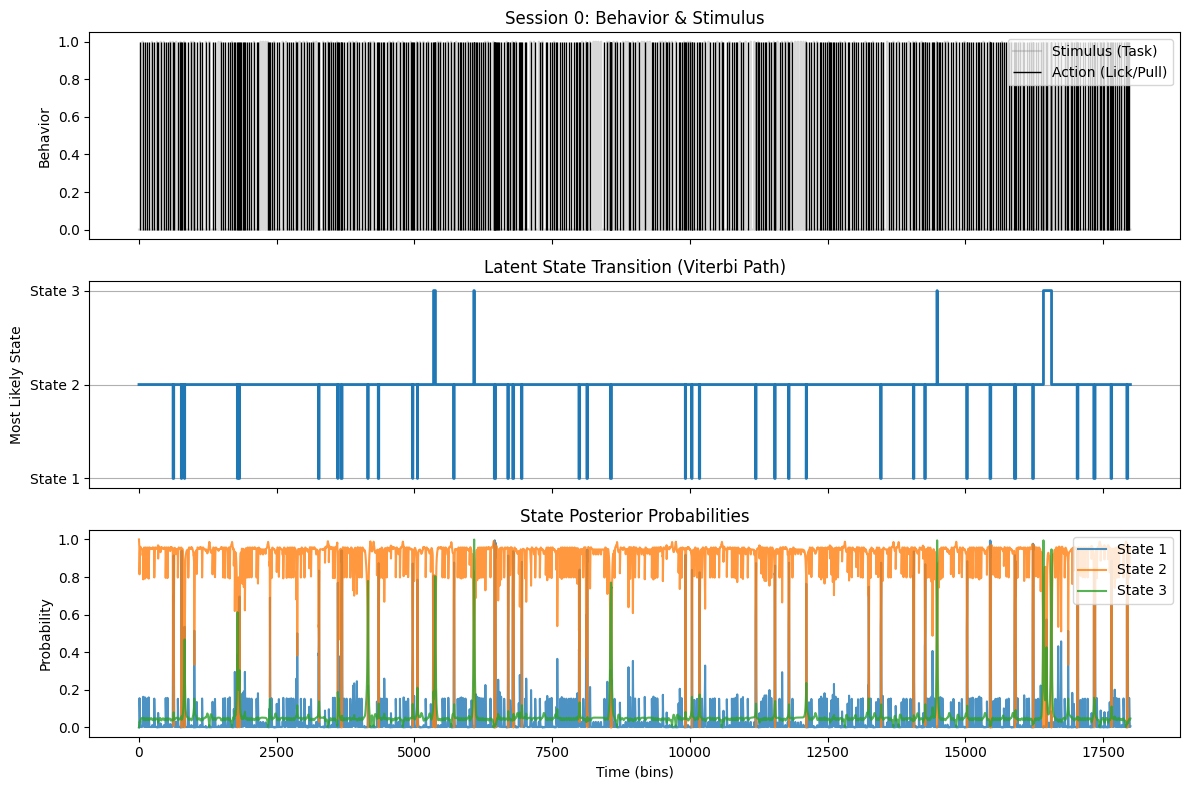

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# --- A. 学習曲線の確認 (Log Likelihood History) ---
# 前回の train_glmhmm 関数内で `lls = glmhmm.fit(...)` の戻り値リストを使用します。
# もし手元にリストがなければ、モデルオブジェクトに保存されている場合がありますが、
# ssmの仕様上、fitの戻り値をプロットするのが確実です。
# (前回のコードを再実行して lls を取得するか、以下のように確認してください)

# ※ここでは前回の実行で `lls` (各イテレーションの尤度リスト) が取得できていると仮定してプロットします
# もし `lls` がなければ、とりあえず可視化パートへ進んでください。

plt.figure(figsize=(6, 4))
plt.plot(lls, label="EM Log Likelihood")
plt.xlabel("Iteration")
plt.ylabel("Log Likelihood")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()


# --- B. 時系列でのState変化の可視化 ---

# 可視化したいセッション（データセット）のインデックス
sess_idx = 0  # 0番目のデータを可視化

# データの取得
y_true = train_ys[sess_idx]   # 実データ (Action)
x_in = train_xs[sess_idx]     # 入力 (Bias, Stimulus, Histories)

# 1. 最尤状態系列 (Viterbi Path): 最もありえる状態の遷移 (0, 1, 2...)
# 参照: notebooks/2b Input Driven Observations (GLM-HMM).ipynb
z_most_likely = model.most_likely_states(y_true, input=x_in)

# 2. 状態事後確率 (Posterior Probabilities): 各時刻で各状態にいる確率 (0.0 ~ 1.0)
# 参照: notebooks/2b Input Driven Observations (GLM-HMM).ipynb
expected_states = model.expected_states(data=y_true, input=x_in)[0]


# --- プロット作成 ---
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# 上段: 実際の行動 (Action) と 刺激 (Stimulus)
# Stimulusは train_xs の 2列目 (インデックス1) にあると仮定 (要件定義より)
stim_trace = x_in[:, 1]
time_bins = np.arange(len(y_true))

axes[0].plot(time_bins, stim_trace, color='gray', alpha=0.3, label="Stimulus (Task)")
axes[0].vlines(time_bins[y_true.flatten() == 1], 0, 1, color='black', linewidth=1, label="Action (Lick/Pull)")
axes[0].set_ylabel("Behavior")
axes[0].set_title(f"Session {sess_idx}: Behavior & Stimulus")
axes[0].legend(loc="upper right")

# 中段: 最尤状態 (Discrete State Sequence)
# 状態ごとに色を変えて背景を塗る、またはStepプロット
cmap = plt.get_cmap("tab10")
K = model.K  # 状態数

# 背景色として状態を表示
for k in range(K):
    # 状態 k である区間を塗りつぶし（視覚的にわかりやすくするため）
    # 簡易的に imshow を使う方法もあります
    pass

# ここではシンプルにステップ線で表示
axes[1].step(time_bins, z_most_likely, where='post', color='tab:blue', linewidth=2)
axes[1].set_yticks(range(K))
axes[1].set_yticklabels([f"State {k+1}" for k in range(K)])
axes[1].set_ylabel("Most Likely State")
axes[1].set_title("Latent State Transition (Viterbi Path)")
axes[1].grid(axis='y')

# 下段: 状態確率 (State Probabilities)
# 状態があいまいな区間を確認できます
for k in range(K):
    axes[2].plot(time_bins, expected_states[:, k], label=f"State {k+1}", color=cmap(k), alpha=0.8)

axes[2].set_ylabel("Probability")
axes[2].set_xlabel("Time (bins)")
axes[2].set_title("State Posterior Probabilities")
axes[2].legend(loc="upper right")
axes[2].set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

Training GLM-HMM with K=2 states...


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Best Log Likelihood (K=2): -2007.91


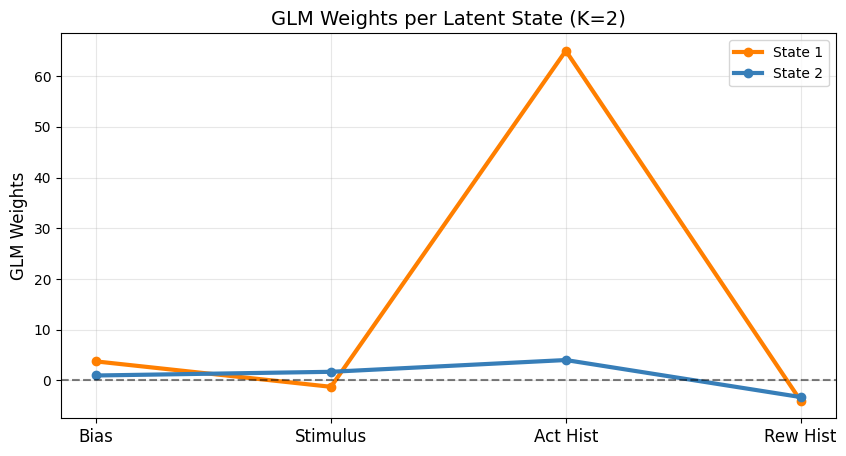


Transition Matrix (K=2):
[[0.991 0.009]
 [0.146 0.854]]


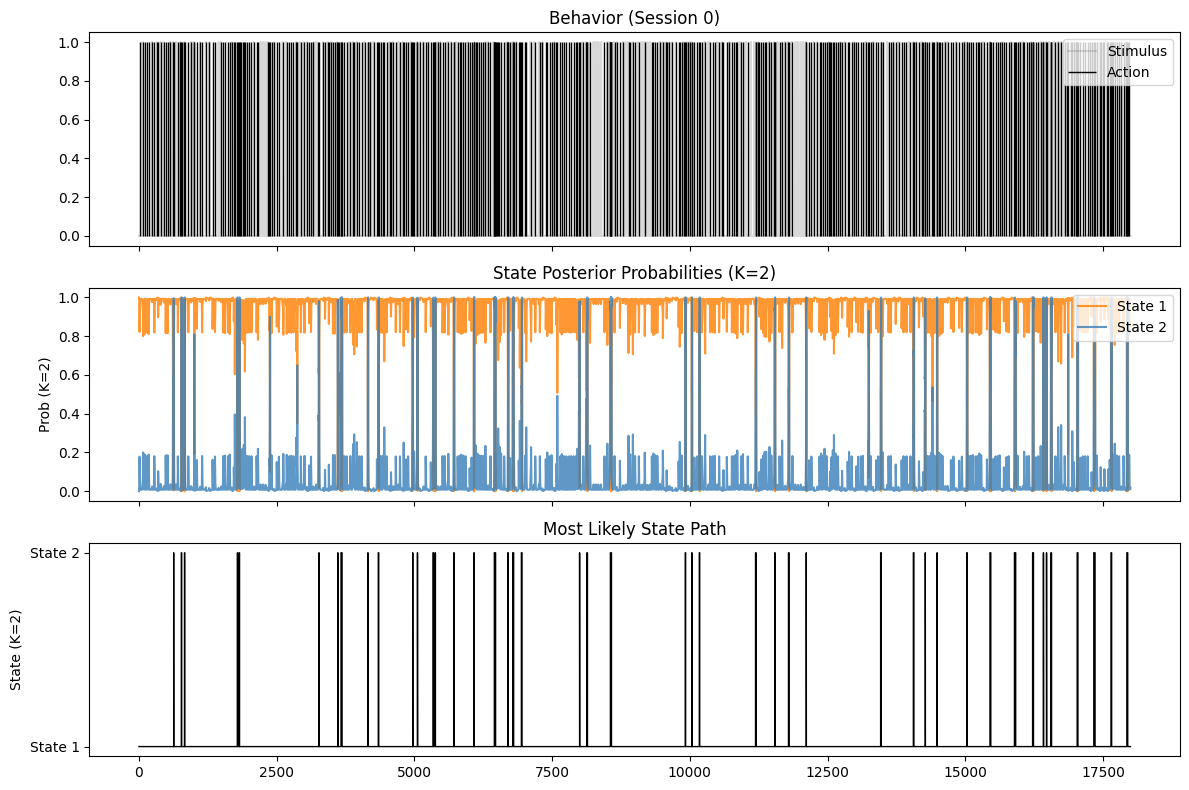

In [26]:
import numpy as np
import ssm
import matplotlib.pyplot as plt

# --- 1. K=2 モデルの学習 ---
# 前回の関数を流用・簡略化して K=2 で実行します
print("Training GLM-HMM with K=2 states...")

# 状態数
K = 2
obs_dim = 1
input_dim = 4  # Bias, Stimulus, ActHist, RewHist
num_categories = 2

# 複数シードで学習
seeds = [0, 1, 2, 3, 4]
best_model_k2 = None
best_ll_k2 = -np.inf

for seed in seeds:
    np.random.seed(seed)
    glmhmm = ssm.HMM(K, obs_dim, input_dim,
                     observations="input_driven_obs",
                     observation_kwargs=dict(C=num_categories),
                     transitions="standard")

    try:
        # train_ys, train_xs は既にメモリにある前提
        lls = glmhmm.fit(train_ys, inputs=train_xs, method="em", num_iters=200, tolerance=10**-4)
        if lls[-1] > best_ll_k2:
            best_ll_k2 = lls[-1]
            best_model_k2 = glmhmm
    except Exception as e:
        continue

print(f"Best Log Likelihood (K=2): {best_ll_k2:.2f}")

# --- 2. 重みの可視化 (K=2) ---
glm_weights_k2 = best_model_k2.observations.params
feature_names = ['Bias', 'Stimulus', 'Act Hist', 'Rew Hist']
colors = ['#ff7f00', '#377eb8'] # 2色

plt.figure(figsize=(10, 5))
for k in range(K):
    w_k = glm_weights_k2[k][0]
    plt.plot(range(len(feature_names)), w_k, marker='o',
             label=f'State {k+1}', color=colors[k], linewidth=3)

plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.xticks(range(len(feature_names)), feature_names, fontsize=12)
plt.ylabel("GLM Weights", fontsize=12)
plt.title("GLM Weights per Latent State (K=2)", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- 3. 遷移確率行列 (K=2) ---
trans_mat_k2 = np.exp(best_model_k2.transitions.params)[0]
print("\nTransition Matrix (K=2):")
print(np.round(trans_mat_k2, 3))

# --- 4. 時系列でのState変化の可視化 (K=2 vs K=3 比較用) ---
# サンプルセッションの取得
sess_idx = 0
y_true = train_ys[sess_idx]
x_in = train_xs[sess_idx]

# 推定
z_k2 = best_model_k2.most_likely_states(y_true, input=x_in)
prob_k2 = best_model_k2.expected_states(data=y_true, input=x_in)[0]

# プロット
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
time_bins = np.arange(len(y_true))

# 行動データ
axes[0].plot(time_bins, x_in[:, 1], color='gray', alpha=0.3, label="Stimulus") # Stimulus
axes[0].vlines(time_bins[y_true.flatten() == 1], 0, 1, color='black', linewidth=1, label="Action")
axes[0].set_title(f"Behavior (Session {sess_idx})")
axes[0].legend(loc="upper right")

# K=2 の状態確率
for k in range(K):
    axes[1].plot(time_bins, prob_k2[:, k], label=f"State {k+1}", color=colors[k], alpha=0.8)
axes[1].set_ylabel("Prob (K=2)")
axes[1].set_title("State Posterior Probabilities (K=2)")
axes[1].legend(loc="upper right")

# K=2 のViterbi Path (背景塗りつぶし風)
axes[2].step(time_bins, z_k2, where='post', color='black', linewidth=1)
axes[2].set_ylabel("State (K=2)")
axes[2].set_yticks([0, 1])
axes[2].set_yticklabels(["State 1", "State 2"])
axes[2].set_title("Most Likely State Path")

plt.tight_layout()
plt.show()

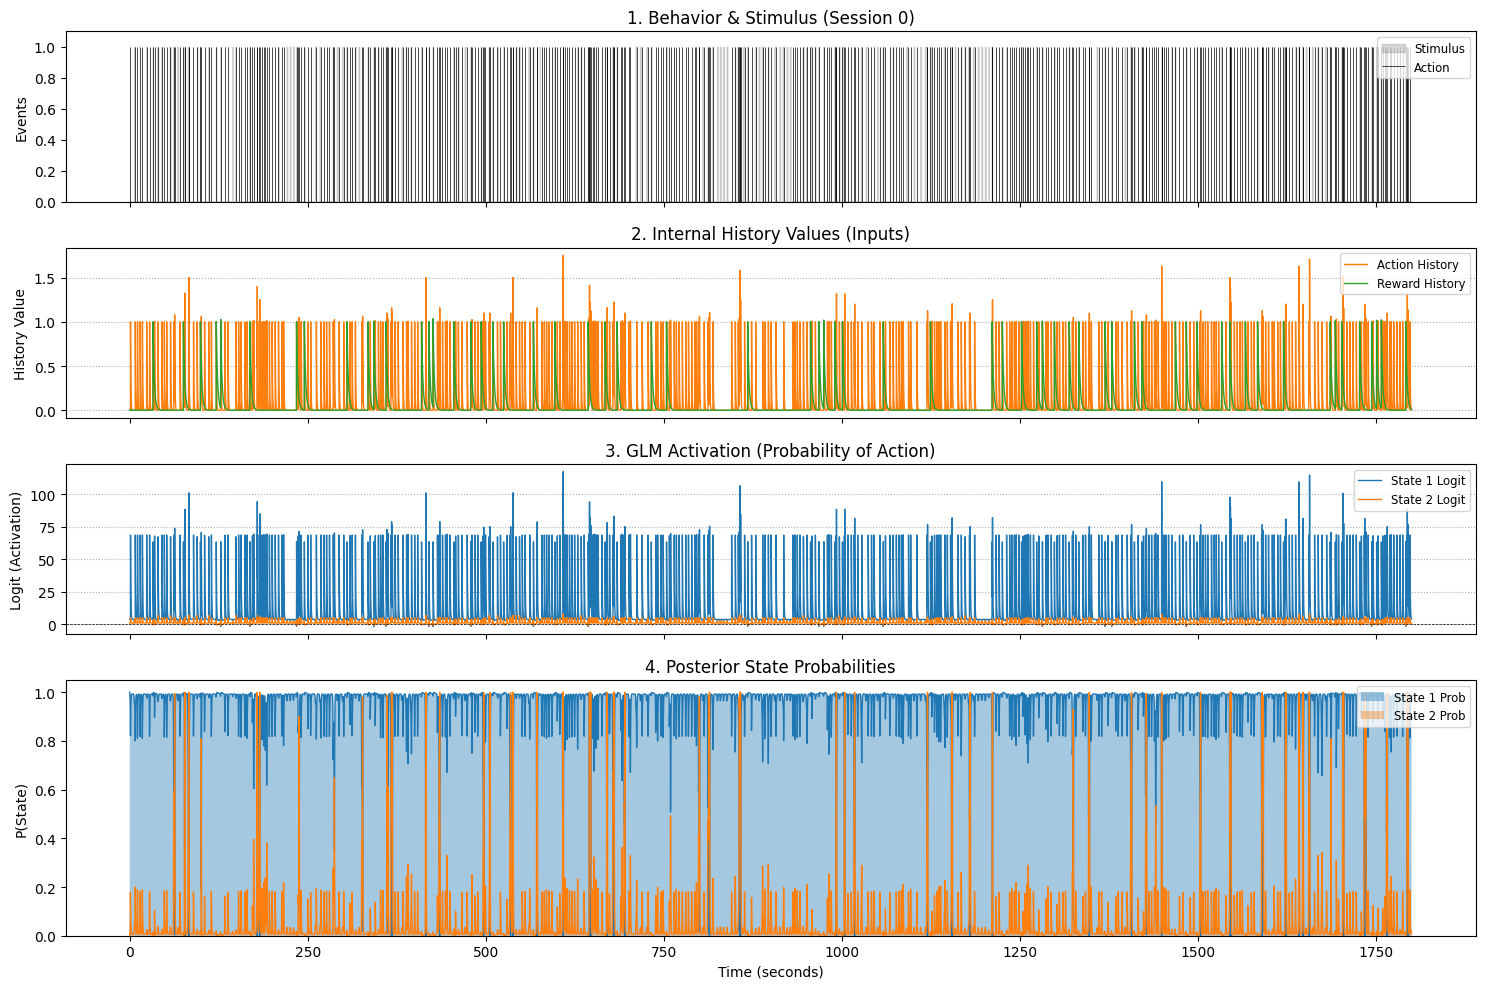

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def plot_session_time_series(model, train_ys, train_xs, sess_idx=0, bin_width=0.1, duration_sec=1800):
    """
    セッションデータを時系列で可視化し、入力特徴量と状態遷移の関係を調査する関数。

    Parameters
    ----------
    model : ssm.HMM
        学習済みモデル
    train_ys, train_xs : list
        データセット
    sess_idx : int
        可視化するセッションのインデックス
    bin_width : float
        1ビンの秒数 (0.1s)
    duration_sec : float
        表示する最大秒数 (1800s)
    """

    # データ取得
    y = train_ys[sess_idx]
    x = train_xs[sess_idx]

    # データ長を秒数で制限（データが短い場合はその長さまで）
    max_bins = int(duration_sec / bin_width)
    n_bins = min(len(y), max_bins)

    y = y[:n_bins]
    x = x[:n_bins]

    # 時間軸作成 (秒)
    time_axis = np.arange(n_bins) * bin_width

    # 状態確率の計算
    posterior = model.expected_states(data=y, input=x)[0]

    # --- プロット設定 ---
    fig, axes = plt.subplots(4, 1, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [1, 1, 1, 1.5]})

    # 1. 行動と刺激 (Raw Behavior)
    # x[:, 1] = Stimulus
    stim = x[:, 1]
    action_times = time_axis[y.flatten() == 1]

    axes[0].fill_between(time_axis, 0, stim, color='gray', alpha=0.3, label="Stimulus", step='pre')
    axes[0].vlines(action_times, 0, 1, color='black', linewidth=0.5, label="Action")
    axes[0].set_ylabel("Events")
    axes[0].set_title(f"1. Behavior & Stimulus (Session {sess_idx})")
    axes[0].legend(loc="upper right", fontsize='small')
    axes[0].set_ylim(0, 1.1)

    # 2. 履歴変数の値 (Internal Covariates)
    # x[:, 2] = Action History, x[:, 3] = Reward History
    act_hist = x[:, 2]
    rew_hist = x[:, 3]

    axes[1].plot(time_axis, act_hist, color='tab:orange', linewidth=1, label="Action History")
    axes[1].plot(time_axis, rew_hist, color='tab:green', linewidth=1, label="Reward History")
    axes[1].set_ylabel("History Value")
    axes[1].set_title("2. Internal History Values (Inputs)")
    axes[1].legend(loc="upper right", fontsize='small')
    axes[1].grid(True, axis='y', linestyle=':')

    # 3. GLMの入力総和 (GLM Activation)
    # 状態ごとの「行動しやすさ (Logit)」を計算: w^T * x
    # これがプラスなら行動確率 > 50%, マイナスなら < 50%
    glm_weights = model.observations.params # (K, 1, M)

    for k in range(model.K):
        # shape: (T, M) dot (M, ) -> (T, )
        activation = np.dot(x, glm_weights[k][0])
        axes[2].plot(time_axis, activation, label=f"State {k+1} Logit", linewidth=1)

    axes[2].axhline(0, color='black', linestyle='--', linewidth=0.5)
    axes[2].set_ylabel("Logit (Activation)")
    axes[2].set_title("3. GLM Activation (Probability of Action)")
    axes[2].legend(loc="upper right", fontsize='small')
    axes[2].grid(True, axis='y', linestyle=':')

    # 4. 状態確率 (Posterior Probability)
    for k in range(model.K):
        axes[3].fill_between(time_axis, 0, posterior[:, k], alpha=0.4, label=f"State {k+1} Prob")
        axes[3].plot(time_axis, posterior[:, k], linewidth=1)

    axes[3].set_ylabel("P(State)")
    axes[3].set_xlabel("Time (seconds)")
    axes[3].set_title("4. Posterior State Probabilities")
    axes[3].legend(loc="upper right", fontsize='small')
    axes[3].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

# 実行 (best_model_k2 が存在することを前提)
try:
    plot_session_time_series(best_model_k2, train_ys, train_xs, sess_idx=0, duration_sec=1800)
except NameError:
    print("モデル 'best_model_k2' が見つかりません。学習コードを実行してください。")

Training GLM-HMM (K=2) with MAP Estimation (prior_sigma=2.0)...


  0%|          | 0/200 [00:00<?, ?it/s]

Seed 0: Final Score (Log Prob) = -2019.43


  0%|          | 0/200 [00:00<?, ?it/s]

Seed 1: Final Score (Log Prob) = -2035.80


  0%|          | 0/200 [00:00<?, ?it/s]

Seed 2: Final Score (Log Prob) = -2019.55

Recovered Weights with Regularization:
State 1: [ 3.93 -1.57  8.38 -2.47]
State 2: [ 2.22  0.78  1.65 -1.46]


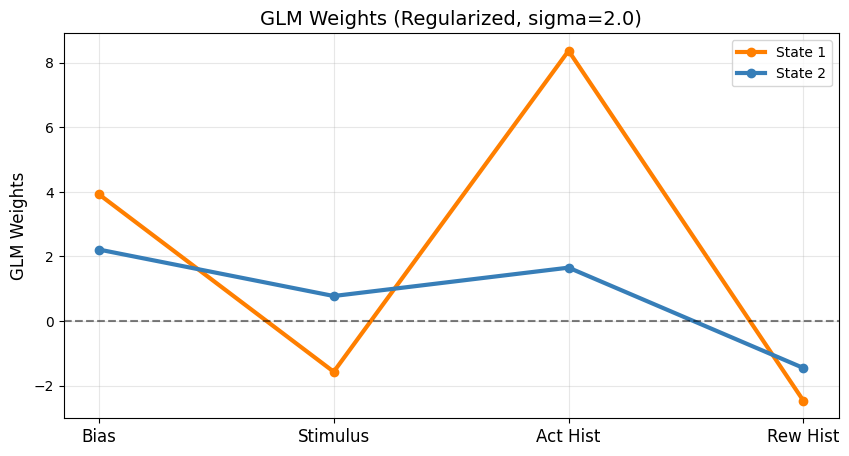


Transition Matrix:
[[0.987 0.013]
 [0.132 0.868]]


In [33]:
import numpy as np
import ssm
import matplotlib.pyplot as plt

def train_glmhmm_map(train_ys, train_xs, num_states=2, prior_sigma=2.0, num_iters=200, seeds=[0]):
    """
    L2正則化（MAP推定）を用いてGLM-HMMを学習する関数。

    Parameters
    ----------
    prior_sigma : float
        重みの事前分布の標準偏差。小さいほど正則化が強い（重みが大きくなりにくい）。
        推奨値: 1.0 ~ 5.0 (データのスケールによるが、今回は入力が0~1.5程度なので2.0付近が妥当)
    """

    obs_dim = 1
    input_dim = 4
    num_categories = 2

    best_model = None
    best_ll = -np.inf

    print(f"Training GLM-HMM (K={num_states}) with MAP Estimation (prior_sigma={prior_sigma})...")

    for seed in seeds:
        np.random.seed(seed)

        # --- 変更点: observation_kwargs に prior_sigma を設定 ---
        # これにより、重みが極端に大きくなることにペナルティが課されます
        glmhmm = ssm.HMM(
            K=num_states,
            D=obs_dim,
            M=input_dim,
            observations="input_driven_obs",
            observation_kwargs=dict(
                C=num_categories,
                prior_mean=0,      # 重みの事前平均は0
                prior_sigma=prior_sigma  # 重みの広がりを制限（正則化）
            ),
            transitions="standard"
        )

        try:
            # fit関数はpriorが設定されていれば自動的にMAP推定を行います
            lls = glmhmm.fit(train_ys, inputs=train_xs, method="em", num_iters=num_iters, tolerance=10**-4)

            # MAP推定の場合、戻り値は対数事後確率（Log Probability）になります
            final_score = lls[-1]
            print(f"Seed {seed}: Final Score (Log Prob) = {final_score:.2f}")

            if final_score > best_ll:
                best_ll = final_score
                best_model = glmhmm

        except Exception as e:
            print(f"Seed {seed} failed: {e}")
            continue

    if best_model is None:
        raise RuntimeError("Training failed.")

    return best_model

# --- 実行と確認 ---
try:
    # 正則化を効かせて学習 (prior_sigma=2.0)
    map_model = train_glmhmm_map(train_ys, train_xs, num_states=2, prior_sigma=2.0, seeds=[0, 1, 2])

    # --- 重みの確認 ---
    glm_weights_map = map_model.observations.params
    feature_names = ['Bias', 'Stimulus', 'Act Hist', 'Rew Hist']
    colors = ['#ff7f00', '#377eb8']

    print("\nRecovered Weights with Regularization:")
    for k in range(map_model.K):
        print(f"State {k+1}: {np.round(glm_weights_map[k][0], 2)}")

    plt.figure(figsize=(10, 5))
    for k in range(map_model.K):
        w_k = glm_weights_map[k][0]
        plt.plot(range(len(feature_names)), w_k, marker='o',
                 label=f'State {k+1}', color=colors[k], linewidth=3)

    plt.axhline(0, color='black', linestyle='--', alpha=0.5)
    plt.xticks(range(len(feature_names)), feature_names, fontsize=12)
    plt.ylabel("GLM Weights", fontsize=12)
    plt.title(f"GLM Weights (Regularized, sigma={2.0})", fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # --- 遷移確率の確認 ---
    print("\nTransition Matrix:")
    print(np.round(np.exp(map_model.transitions.params)[0], 3))

except NameError:
    print("Input data not found.")

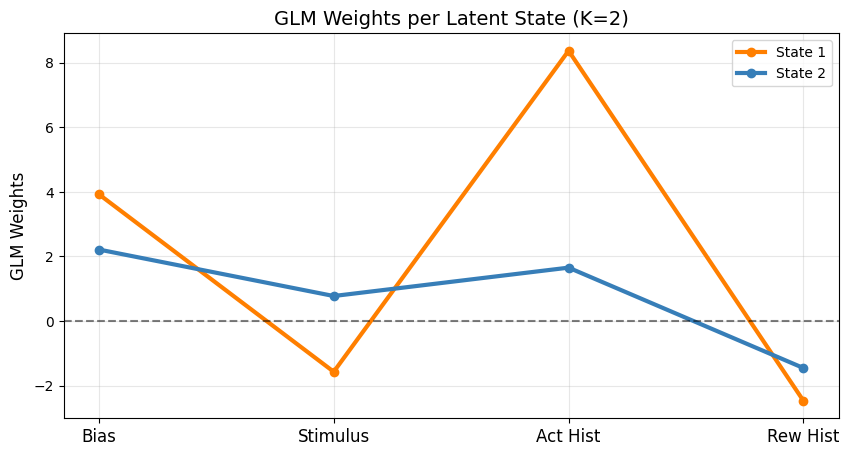


Transition Matrix (K=2):
[[0.991 0.009]
 [0.146 0.854]]


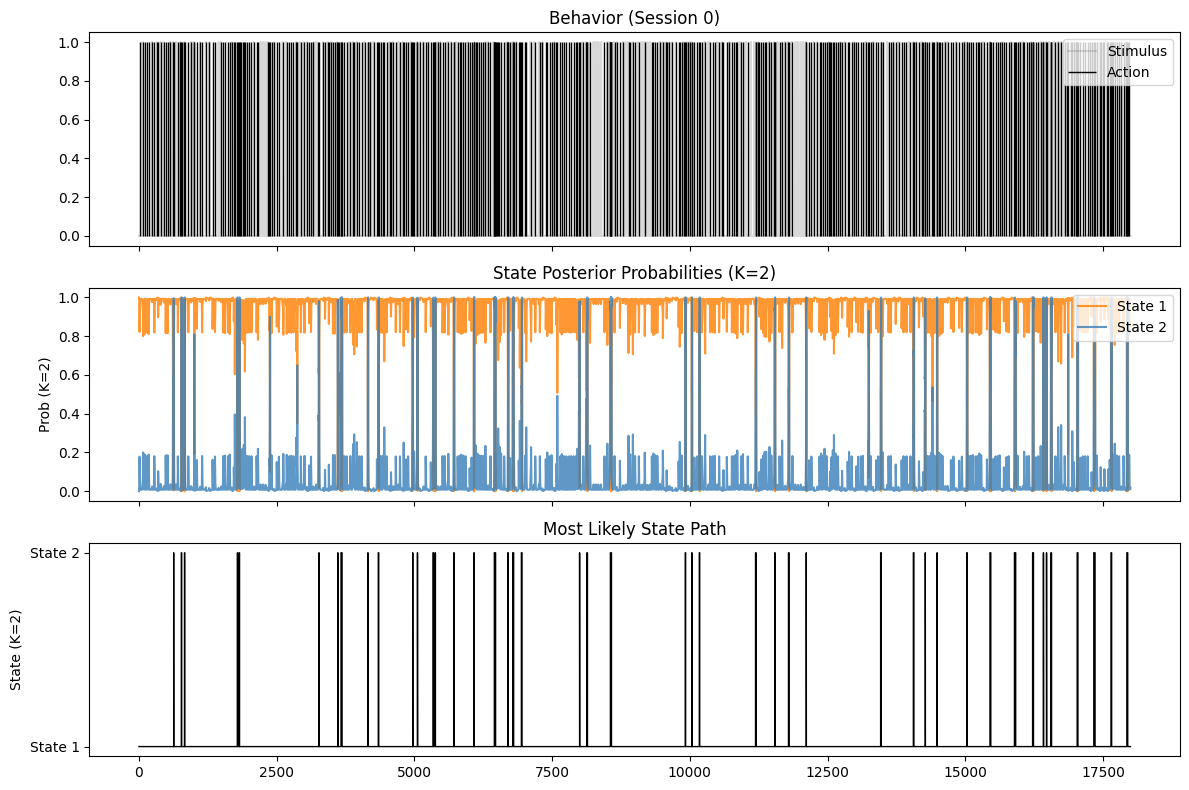

In [35]:
# --- 2. 重みの可視化 (K=2) ---
glm_weights_k2 = map_model.observations.params
feature_names = ['Bias', 'Stimulus', 'Act Hist', 'Rew Hist']
colors = ['#ff7f00', '#377eb8'] # 2色

plt.figure(figsize=(10, 5))
for k in range(K):
    w_k = glm_weights_k2[k][0]
    plt.plot(range(len(feature_names)), w_k, marker='o',
             label=f'State {k+1}', color=colors[k], linewidth=3)

plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.xticks(range(len(feature_names)), feature_names, fontsize=12)
plt.ylabel("GLM Weights", fontsize=12)
plt.title("GLM Weights per Latent State (K=2)", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- 3. 遷移確率行列 (K=2) ---
trans_mat_k2 = np.exp(best_model_k2.transitions.params)[0]
print("\nTransition Matrix (K=2):")
print(np.round(trans_mat_k2, 3))

# --- 4. 時系列でのState変化の可視化 (K=2 vs K=3 比較用) ---
# サンプルセッションの取得
sess_idx = 0
y_true = train_ys[sess_idx]
x_in = train_xs[sess_idx]

# 推定
z_k2 = best_model_k2.most_likely_states(y_true, input=x_in)
prob_k2 = best_model_k2.expected_states(data=y_true, input=x_in)[0]

# プロット
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
time_bins = np.arange(len(y_true))

# 行動データ
axes[0].plot(time_bins, x_in[:, 1], color='gray', alpha=0.3, label="Stimulus") # Stimulus
axes[0].vlines(time_bins[y_true.flatten() == 1], 0, 1, color='black', linewidth=1, label="Action")
axes[0].set_title(f"Behavior (Session {sess_idx})")
axes[0].legend(loc="upper right")

# K=2 の状態確率
for k in range(K):
    axes[1].plot(time_bins, prob_k2[:, k], label=f"State {k+1}", color=colors[k], alpha=0.8)
axes[1].set_ylabel("Prob (K=2)")
axes[1].set_title("State Posterior Probabilities (K=2)")
axes[1].legend(loc="upper right")

# K=2 のViterbi Path (背景塗りつぶし風)
axes[2].step(time_bins, z_k2, where='post', color='black', linewidth=1)
axes[2].set_ylabel("State (K=2)")
axes[2].set_yticks([0, 1])
axes[2].set_yticklabels(["State 1", "State 2"])
axes[2].set_title("Most Likely State Path")

plt.tight_layout()
plt.show()